In [1]:
!git clone https://github.com/dhrim/darkeras-yolov4

Cloning into 'darkeras-yolov4'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 162 (delta 79), reused 34 (delta 15), pack-reused 0
Receiving objects: 100% (162/162), 5.57 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [2]:
%cd darkeras-yolov4

/content/darkeras-yolov4


# 모델 파일 다운로드

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
!cp /gdrive/MyDrive/tmp/*last.weights ./

In [5]:
!ls -al *.weights

-rw------- 1 root root 256015980 Jan 11 09:50 yolo-obj_last.weights
-rw------- 1 root root 246305388 Jan 11 09:50 yolov3_custom_last.weights
-rw------- 1 root root  35434956 Jan 11 09:50 yolov3-tiny_custom_last.weights
-rw------- 1 root root 257717640 Jan 11 09:50 yolov4_custom_last.weights


copy from https://github.com/tranleanh/darkeras-yolov4/blob/main/darkeras-yolov3.ipynb

# 데이터 다운로드

In [6]:
# !cp /gdrive/MyDrive/tmp/laptops_labeled.zip ./

In [7]:
# !unzip laptops_labeled.zip

In [8]:
!unzip /gdrive/MyDrive/tmp/Raccoon.zip -d Raccoon

Archive:  /gdrive/MyDrive/tmp/Raccoon.zip
   creating: Raccoon/test/
  inflating: Raccoon/test/_darknet.labels  
  inflating: Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.jpg  
  inflating: Raccoon/test/raccoon-57_jpg.rf.26f3fae218f26088f6a7405c58ae8020.txt  
  inflating: Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.jpg  
  inflating: Raccoon/test/raccoon-58_jpg.rf.ff9de9977475e0086e7ab582122c5167.txt  
  inflating: Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.jpg  
  inflating: Raccoon/test/raccoon-59_jpg.rf.388d6dd8c9d5a6fc7ca75790e680c269.txt  
  inflating: Raccoon/test/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.jpg  
  inflating: Raccoon/test/raccoon-60_jpg.rf.cff8b797e6b5c9b716b6be70be2b6b33.txt  
  inflating: Raccoon/test/raccoon-61_jpg.rf.58c4f561336525f59d395ce21508523b.jpg  
  inflating: Raccoon/test/raccoon-61_jpg.rf.58c4f561336525f59d395ce21508523b.txt  
  inflating: Raccoon/test/raccoon-62_jpg.rf.e997ede5457f0

# 모델 생성

In [9]:
import yolov3_wrapper
model = yolov3_wrapper.YoloV3Wrapper("yolov3_custom_last.weights", class_num=1)

In [10]:
# model.save("custom_model.h5")

# 이미지 로딩

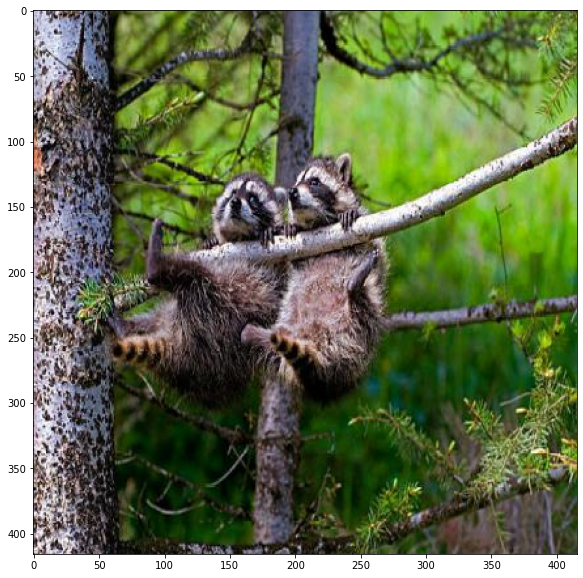

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

INPUT_SIZE = 608

image_path = "Raccoon/test/raccoon-63_jpg.rf.1b33356e79739a8a1f3676a9f4f9f97a.jpg"
image      = cv2.imread(image_path)
image      = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,10))
plt.imshow(image)
plt.show()

# 탐지 실행

In [12]:
bboxes = model.predict(image)

In [13]:
print(len(bboxes))
for bbox in bboxes:
    print(bbox)

1
[ 29.09693718  87.75128937 335.93508911 382.86395264   0.96003932
   0.        ]


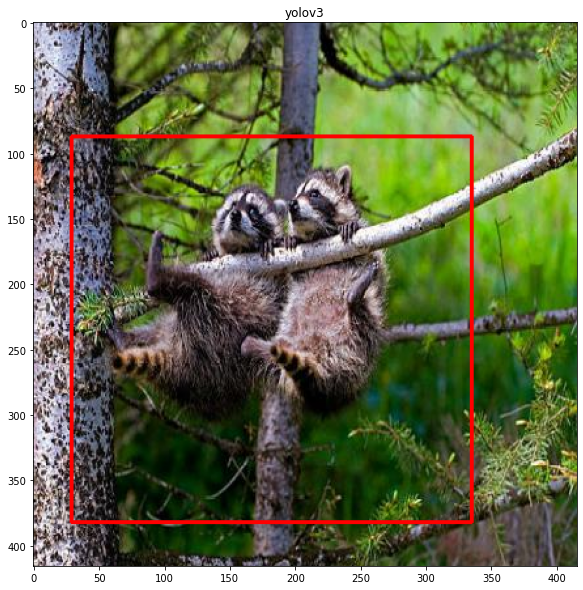

In [14]:
dummy = np.copy(image)

for box in bboxes:
    
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    conf = box[4]
    cls_id = int(box[5])
        
    dummy = cv2.rectangle(dummy, (x1,y1), (x2,y2), (255,0,0), 2)
     
plt.figure(figsize=(12,10))
plt.gca().set_title("yolov3"), plt.imshow(dummy)
plt.show()

# 박스 그리기

In [15]:
class_names = [ "laptop", "keyboard" ]

In [16]:
import core
import colorsys
import random

def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """

    try:
        classes = class_names
    except NameError:
        classes = core.utils.read_class_names("./data/classes/coco.names")

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image


In [17]:
image = draw_bbox(image, bboxes)

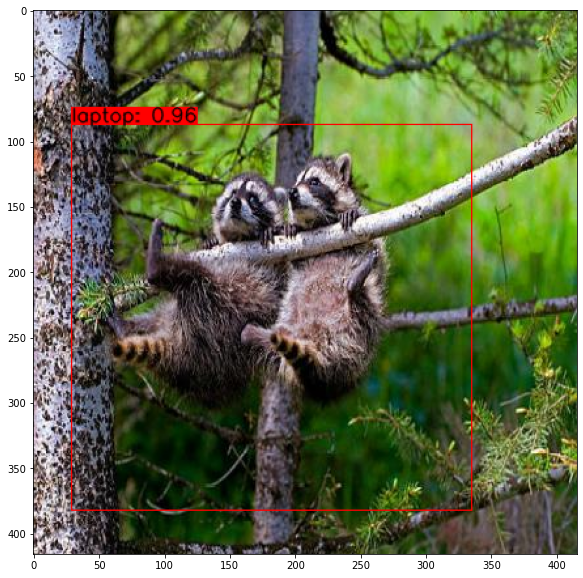

In [18]:
plt.figure(figsize=(12,10))
plt.imshow(image)
plt.show()

In [19]:
cv2.imwrite("detections_yolov3.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

True